In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 72)          23616     
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           73        
Total params: 23,689
Trainable params: 23,689
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 140ms/step
loss: 8.557e-01
mean_absolute_error: 7.373e-01
R_squared: 8.843e-01
pearson_r: 9.413e-01
fac2: 1.000e+00


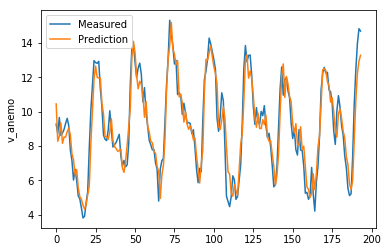

In [3]:
sys.meta_path.append(NotebookFinder())

import argparse
import pandas as pd
import rnn
import data

#parser = argparse.ArgumentParser()

NEURONS = [72]
LR = 1e-3
TYPE = 'lstm'
HOURS = 1
EPOCH = 100
BATCH = 20
MULTIPLIER = 7

"""
parser.add_argument(
  "-n", "--neurons", 
  nargs="+", help="Number of Neurons for each Dense hidden layer", type=int)
parser.add_argument("-lr", "--learning", help="Learning Rate", type=float)
parser.add_argument("-t", "--type", help="Layer type (either gru or lstm)", type=str)

parser.add_argument("-hours", "--hours", help="Number of hours to consider for prediction", type=int)
parser.add_argument("-e", "--epochs", help="Number of epochs", type=int)
parser.add_argument("-b", "--batch", help="Batch size", type=int)
parser.add_argument("-m", "--multiplier", help="Number of times the interval of hours should be repeated", type=int)
"""

try:
    if TYPE != 'gru' and TYPE != 'lstm':
        raise ValueError("Invalid type")
    
    shift_days = 1

    shift_steps = shift_days * HOURS

    filename = "dataset.csv"
    dataset = pd.read_csv(filename, header=0, index_col=0)

    processor = data.DataProcessor(dataset)
    processor.shift(shift_steps)

    x_data, y_data = processor.to_numpy_arrays(shift_steps)
    processor.build_dataset(x_data, y_data)

    #processor.scale()
    #reframed = processor.series_to_supervised(hours, 1)

    mld = rnn.KerasRNN(processor,NEURONS,LR,TYPE,HOURS,EPOCH,BATCH,MULTIPLIER)

    mld.build_model()
    
    try:
        mld.model.load_weights(mld.checkpoint)

        mld.evaluate()
        mld.predict()
    except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)
        mld.train()
        mld.evaluate()
        mld.predict()

except ValueError as e:
    print ('Error: ' + e.message)
